1/1 [==============================] - 0s 42ms/step


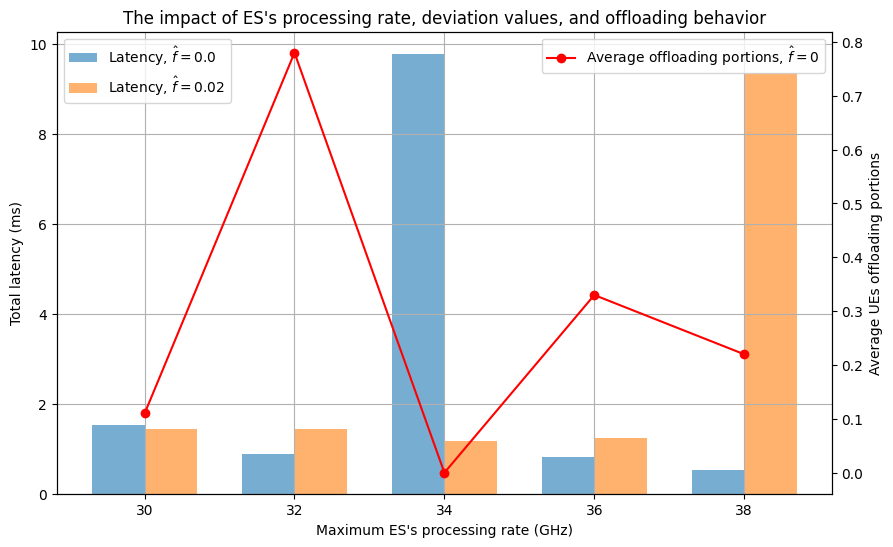

In [9]:
# Assuming you have the EdgeComputingEnvironment and DDQNAgent defined as per your code
env = EdgeComputingEnvironment()

# Define the number of users/devices
num_users = env.M

# Define the different F_max_es values and deviation values
F_max_es_values = [30, 32, 34, 36, 38]
deviation_values = [0.0, 0.02]

# Initialize the DDQN agent
agent = DDQNAgent(env, num_users)

# Define the number of episodes for training and testing steps
num_train_episodes = 1  # or any suitable number for training
num_test_steps = 1  # or any suitable number for testing

# Create the folder for DDQN model files if it doesn't exist
model_folder = 'DDQN_Models_Test2'
os.makedirs(model_folder, exist_ok=True)

# Storage for results
results = []

# Train and save DDQN models
for deviation in deviation_values:
    env.f_es_dev = deviation
    env.f_ue_dev = deviation

    for F_max_es in F_max_es_values:
        env.F_max_es = F_max_es * 1e9  # Convert GHz to Hz

        # Train the agent
        agent.train(num_train_episodes)

        # Save the model for this configuration
        model_filename = os.path.join(model_folder, f'DDQN_model_F{F_max_es}_Dev{deviation}.h5')
        agent.save(model_filename)

# Test and collect metrics
for deviation in deviation_values:
    for F_max_es in F_max_es_values:
        # Load the model for this configuration
        model_filename = os.path.join(model_folder, f'DDQN_model_F{F_max_es}_Dev{deviation}.h5')
        agent.load(model_filename)

        env.f_es_dev = deviation
        env.f_ue_dev = deviation
        env.F_max_es = F_max_es * 1e9  # Convert GHz to Hz

        # Test the agent and get the average delay and alpha
        avg_delay, avg_alpha = agent.test(num_test_steps)

        # Store the results
        results.append({
            'F_max_es': F_max_es,
            'f_dev': deviation,
            'avg_delay': avg_delay,
            'avg_alpha': avg_alpha
        })

# Prepare data for plotting
delays_data = {deviation: [] for deviation in deviation_values}
alphas_data = {deviation: [] for deviation in deviation_values}

# Fill the data lists with default values if missing
for F_max_es in F_max_es_values:
    for deviation in deviation_values:
        found = False
        for result in results:
            if result['F_max_es'] == F_max_es and result['f_dev'] == deviation:
                delays_data[deviation].append(result['avg_delay'][0] if isinstance(result['avg_delay'], np.ndarray) else result['avg_delay'])
                if deviation == 0:
                    alphas_data[deviation].append(result['avg_alpha'])
                found = True
                break
        if not found:
            delays_data[deviation].append(0)
            if deviation == 0:
                alphas_data[deviation].append(0)

# Plotting the results
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for delay
bar_width = 0.35
index = np.arange(len(F_max_es_values))

for i, deviation in enumerate(deviation_values):
    ax1.bar(index + i * bar_width, delays_data[deviation], bar_width, label=f'Latency, $\hat{{f}} = {deviation}$', alpha=0.6)

ax1.set_xlabel("Maximum ES's processing rate (GHz)")
ax1.set_ylabel("Total latency (ms)")
ax1.set_title("The impact of ES's processing rate, deviation values, and offloading behavior")
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(F_max_es_values)
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot for average alphas
ax2 = ax1.twinx()
alphas = alphas_data[0]
ax2.plot(index + bar_width / 2, alphas, marker='o', color='red', label='Average offloading portions, $\hat{f} = 0$')

ax2.set_ylabel("Average UEs offloading portions")
ax2.legend(loc='upper right')

plt.show()
